<a href="https://colab.research.google.com/github/riccardotomada/Airfoil-Analysis/blob/master/Advection%20DIffusion%20equation/ROM%20linear/POD_utilities_and_datasets_AD_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing FEnICS
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin 

In [2]:
# Importing the libraries needed
from fenics import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.stats import qmc
import csv
from sklearn.decomposition import PCA

In [3]:
# FOM construction

# Generating the mesh
nx, ny = 50, 50
mesh = UnitSquareMesh(nx, ny)
dim = mesh.geometric_dimension()
print(dim)
mesh.coordinates().shape

2


(2601, 2)

In [4]:
# Setting up the measures
dx = Measure('dx', domain=mesh)

In [5]:
# Definition of finite element space
degree = 2
V = FunctionSpace(mesh, 'CG', degree)

In [6]:
# Data of the problem
bx, by = np.cos(np.pi/4.0), np.cos(np.pi/4.0)
b = Constant((bx, by))
f = Constant(0)

In [7]:
# Generating the sampling grid to retrieve the SNapshots 

x_min, x_max = 0, 1
y_min, y_max = 0, 1
grid_dim = 96

x = np.linspace(x_min, x_max, grid_dim)
y = np.linspace(y_min, y_max, grid_dim)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [8]:
# Definition of Dirichlet boundary conditions
gD0 = Constant(0.0)
gD1 = Constant(1.0)

In [9]:
def boundary_right(x, on_boundary):
  return on_boundary and np.isclose(x[0], 1.0)

def boundary_bottom(x, on_boundary):
  return on_boundary and np.isclose(x[1], 0.0)

def boundary_left_bottom(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0.0) and (x[1] <= 0.2)

def boundary_left_top(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0.0) and (x[1] >= 0.2)

def boundary_top(x, on_boundary):
  return on_boundary and np.isclose(x[1], 1.0)

bc1 = DirichletBC(V, gD0, boundary_right)
bc2 = DirichletBC(V, gD1, boundary_bottom)
bc3 = DirichletBC(V, gD1, boundary_left_bottom)
bc4 = DirichletBC(V, gD0, boundary_left_top)
bc5 = DirichletBC(V, gD0, boundary_top)

In [10]:
num_samples     = 80
truncated_modes = 15

import random
random.seed(123)

parameters = np.random.uniform(low=1.0, high=5.0, size=(num_samples))

Snapshots = np.zeros((10201, parameters.shape[0]))
Snapshot_ae  = np.zeros((grid_dim**2,1))
Snapshots_ae = np.zeros((grid_dim**2, parameters.shape[0]))

for iter in range(parameters.shape[0]):
  mu  = 10**(-parameters[iter])
  u = TrialFunction(V)
  v = TestFunction(V)

  a0 = (mu * dot(grad(u), grad(v))) * dx
  a1 = (dot(b, grad(u)) * v) * dx
  a  = a0 + a1
  L = f * v * dx

  # ... stabilization term
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  Pe = bnorm*h/(2*mu)
  tau = 0.5*h/bnorm * conditional(Pe/3 > 1, 1, Pe/3)

  # ... streamline diffusion stabilization
  c = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx 
  a_stab = a + c

  # 4. solving discrete problem
  u = Function(V)
  solve(a_stab == L, u, [bc1, bc2, bc3, bc4, bc5])

  Snapshot = np.array(u.vector())
  Snapshots[:, iter] = Snapshot
  for i in range(X.shape[0]):
    Snapshot_ae[i] = u(X[i][0], X[i][1])
  Snapshots_ae[:, iter] = Snapshot_ae[:,0]

Output streaming troncato alle ultime 5000 righe.
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0906231 seconds.

INFO:FFC:Compiler stage 2: Computing interme

In [11]:
# Performing the Singular Value Decomposition on the Snapshots matrix
UU, SS, VV = np.linalg.svd(Snapshots, full_matrices=False)

In [12]:
# Inspecting the Singular Values
my_model = PCA(n_components = 0.999, svd_solver='full')
my_model.fit_transform(Snapshots)

n_modes = my_model.explained_variance_ratio_.cumsum().shape[0]
print("The number of modes required to capture the 99% of the variance is: " + str(n_modes))

The number of modes required to capture the 99% of the variance is: 4


(9216, 80)
(10201, 80)
(10201, 15)


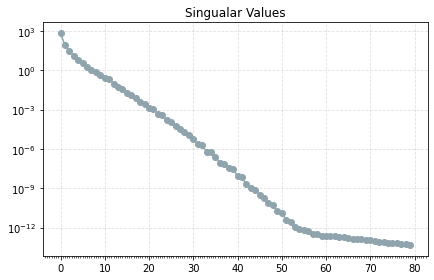

In [13]:
# Plotting the Singular Values
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(SS, marker="o", color = '#90A4AE')
plt.title("Singualar Values")
ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.grid(alpha = 0.4, linestyle='--')
fig.tight_layout()
ax.set_yscale('log')

print(Snapshots_ae.shape)
print(UU.shape)

UU = UU[:, :truncated_modes]
print(UU.shape)

In [14]:
# Retrieving the terms of the FOM for the PINN-approach
# Note: the RHS changes for each parameter
import random
random.seed(123)
num_pinn = 128

parameters_pinn = np.random.uniform(low=1.0, high=5.0, size=(num_pinn))

L = f * v * dx
b_l = assemble(L)
bc1.apply(b_l)
bc2.apply(b_l)
bc3.apply(b_l)
bc4.apply(b_l)
bc5.apply(b_l)

b_l = np.array(b_l)

LEFT_SIDE  = np.zeros((truncated_modes, truncated_modes, num_pinn))
RIGHT_SIDE = np.matmul(np.transpose(UU), b_l) 

for iter in range(num_pinn):

  mu  = 10**(-parameters_pinn[iter])
  u = TrialFunction(V)
  v = TestFunction(V)

  a0 = (mu * dot(grad(u), grad(v))) * dx
  a1 = (dot(b, grad(u)) * v) * dx
  a  = a0 + a1
  L = f * v * dx

  # ... stabilization term
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  Pe = bnorm*h/(2*mu)
  tau = 0.5*h/bnorm * conditional(Pe/3 > 1, 1, Pe/3)

  # ... streamline diffusion stabilization
  c = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx 
  a_stab = a + c
  a_stab = assemble(a_stab)
  bc1.apply(a_stab)
  bc2.apply(a_stab)
  bc3.apply(a_stab)
  bc4.apply(a_stab)
  bc5.apply(a_stab)

  a_stab = a_stab.array()
  print(a_stab.shape)
  left_side = np.matmul(np.transpose(UU), a_stab)
  left_side = np.matmul(left_side, UU)
  LEFT_SIDE[:, :, iter] = left_side

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_20b43aae6e05daa6b873c1a95765458a739b5a0a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_33d3068569dddf22c355109718d125971e2c0e08

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6a53b3ddb2f3691dba09973055a91984de4fd85b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_157d244fcf84dfb120907d720c0fbab330cd86e0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fd193e5a32fc0ab712077eb7045071f8cf492b03

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0f7d5eddabda187db380d3c0e153c7e42346ef39

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8e9ec4bc89a0d3d4d6ac70103aed270a9f3c12c5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d2b9504b4196281cc586c67491c7d886769421ed

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8c212d6f85c78a1730fcbf76cb1d15421d996cd7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9a18eb1d92562dd3de863b28f5663dccf4c4f9b0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e3e5830de7acd39cbb96f2397ad752c31ad4cea2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bc41894214ef25fd59547164c5b0e47d057d012b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d2ea65b5e1dd1350f370193158bd717474914b67

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f20f157c26693c011b0aff62236bee4a9d60fe12

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d9bdb0f22f655fb902e875d6295b09409b024089

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_03cb95232849f05e1bc821888658038a0fe2e2c0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e46bf065b271b2dfafbbb8e186b352781bae6c36

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f5a263bc8a1b027e1191372bc087075974e16c81

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b6c3544f6073793a7c74582d33d99f2cd35c9d42

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_efbf0f7e47ced4d3a09f9825d99b3eb4903e1153

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_34814c4578610759bc1e3a4ff8bcd1801fe94955

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_188682085e7000173d16745d93b9e3a154b40bdf

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_19f776c45cca75e09f5dc75130e90a00e7c6f748

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_605e8fdce3262432576ad451ac9df47ff90631d3

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0a0bc0b5a7102c5c9f961ab18c257912e6b9f4c5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b04087e2c7fc97472e49c30f7cbd7505aa822ec8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_95ea253aa07bf3f44e8746a7f29140859ce94c87

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7cc2cdcb3ffebe23a50a573a557f3c99e9ab9c79

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_98f5d3340961db46cf443591fb4dcf958bdabb84

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e2cc788c223cafcc29e0cd5c28c39b9fe9382b7d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ef9d7affa6689fb17489c622cf9614a8d9bb284d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_95aefa3a202182e444560a5a4be3c05607f80532

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_42ae25f37c5dc5a6518da94fe9ea1461ff304bea

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_aaf34783b55ad20bc221fbf9c5c980d25f7e2d0d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6443390fbba0ab92c010477d50306d00a5ebfe72

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b55722b2d55cde5dc59c7fa4a3016ae8d36ad47a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_375995d9475119b83dcc8edf1df648329ccfe3c8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_561ffb155429387d2c42bb0f78ad5b966e81bf87

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f4cd9a905a49c43ef152a9f7e0cd95aa71c533c5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d77421ad5b39a7b3b8ba9f28fe796906c88ffd2b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_06a2e5c67518267750170e5e1e2981b5fb2ce4fb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0c4c12efeef8cd75e7eb4769945413a1ca79c4b1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0d168edcd63b3d0b379342853c9a4ea1bcad5048

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a91b85406a780a76b5f297b17dc4913a45d3cbc0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_89b93a2d07f1d1c933bf91dbbaeeb3483a3eb1b5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d7a5bef8ebf4faa11e58d9f5ce97a499d2491a6c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e599aa80e97eb2894fa1b88834bfd210f5b4eacb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9d656bf997d23f7b0f70697fc5034c1a179f526b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0ff3a3add41476ad1e604a3ca83955ffc0b578fa

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9062b002f1e3028cf8d3ede84088591d597d5aef

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cbe99de56c21565a3fef0ce371908cdc7f516814

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b32bd9cd081baa9d50d5f7d372efc4cb84225822

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ee6355599498bb71f34c89455093988d7caaa721

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0d7f453b8cb29e43a7fa5c33af3902211fd46375

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d8d94ac0156db7421c85d203a8bdc1cdfe4a71d8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a5ec3c0d8f663ab8cb2b1634ea6d25522652446d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e929ee4ab16ef4344e48972387c4341f2e620c9c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_80c5191f8fb5c43d4665bf560f28c7c65a967739

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a900ab797aaef110fe7fe29b4a6a52574c6b8b43

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7c8c8f7be2c6875fadc6b73d08703906a86c5e50

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4080be3614e7891bd2b92ee70396801002595ff7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2b9f75d33e7243f1f1e869513ec6a2ed2d25c234

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c514c08bad4a1e2a1a9ae5c55131661495aa36dc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2f7281b62c052b721b73a92d53810e04bd60534a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9b64576fd349354b6d92d580973c347e04c13030

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bec2a0bca6fc60f29bba573706f16b191c3a434d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0700932ebed8d94e49a8034787c108d1c6bc8fd4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9229e6720de0fd4bc97f12f940f8ed7dbd395c58

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_98d740a0f9e1082a11b950a75588b41a37bbadb4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_daec65a2ed77c7f42cb5edab0c5087109a91a8da

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b85edd65a8a78af3b08f3333bcbebf0f027e086b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3cbe5a3826f9b91a4263c268d82f93ff0b5720a8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8b222a93eb8c82cb78545c62e6b27dce44a2a32f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4f2f610d27fdb1f063d8e2bb033ca6277d0e3476

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_230f20ea432acd2512a117a39490fdae92542388

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_716df2c582f27eb129205ed7cc0c6815e054d486

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0c35ae8cb957288ea1d441a276c818d29a153346

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_01f3636c633e37581f910579accb6eb381407bf9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3eaf94b0657aa28cd93f58b6765a044f3ca027bc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0fd15123ef245edf65856372611ca1fb219d8a19

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_79c775de87f1fda20c15fbac3a9e6b6f17f461e6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f181f92ae215a7f87fabb90fd7b7d60b6050e019

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3dd7d5e6b06c046e1efebc4162e878279eb8be77

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4b64f984a7ba18b9756a6afe0e7190a8603e9732

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4287357e63d7fbe5d840e91a112f28d9fe4ac654

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ea0e74f7f249b4cb0b49f55ec131fd4f76e1b464

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ed8cff3c2870ee326b1720d7779d45c8cc42629e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a63b0d76c0bd67af524007c5547469557c5d0b36

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9d2200e465f9399ef3ea186109238b16146ff56d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_24a0f663791b8cc026e5598824f96954993261ea

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_823b130ddfdfa01f313e64ffd290326e07218184

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7d2d45d4e3d29fd311c14559fac3d71de5943105

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e2d2a4813e81ce74a3205f83a33179758ecebdc8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_851a01a5a29a2bcfd1fadac98cfd5a5f78ca103d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c671c6ce7d4c2b8514a038b8004fecccf711fa18

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5fdd5b0e266e4abda9b30f05da24bc782cf1cc44

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_64d68a2996f522a034c2dbab6f30c775dedd8619

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_544673601b0d0decba6b66b9e29a295d7b8fdd0e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_42dac8dffa2e4771e9c298e9b5ea92a36214dab2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6837cdd844d39dcd1fd4db0afcf9c83936273d0c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1971bd521d498188f61e4e9eff1040f29ffbea6c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4848dbf3893e21c81692813c0c8d0951bfd5ee4d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fdbc6596924203c75296d643fe0f0325041869c8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_aa6753fca8f9dacb3bedd486b187715e15a5ff9b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_377f963aa8c48d88c5bc6643b016c64a73457b38

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_622d4c91d0a62ce6eed2b153be944965e0ced284

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5474109de56875cba15688852800ad31ab42d75d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0ddd5beb267a44963e9b2498913f1e194ac4fb6c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3c8925911bece63b056808feaded59e80f0955ab

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_56200857afb633c72012888355e66812d87b6489

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_560a89f3d406e78a58643f2644c248e9066e4edb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a7ac389b70260465fc689dba7aa0355cceea0675

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_788f7a5741cccb3dd95426c1107c455f5f4f181e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_85d0932475bdc8ff6358776ae4b3a2ad549373a8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ffe69a5ebe0b55361885ae4f63409cb4c17faff8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d02e9fe2ef2b1c11e0fb8a37bfbbf9c1d5e5f59d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_752b49dfd5dd35cb1c40d4b4b08ae8694e4bb27b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_299a74da64fab32ffba90ad22b3ff751a623fc9f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_85b7ea66fe5e46e5947ae683e337f91d7f1eb8ec

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_de0df0e7c364a5290163a39440237fa095f5932b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5377e1af179695bdb20007222d1123899f71e829

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_22e73c03e79aede8f040ce507822016cfe6e5694

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f38b4bc203a62034720b6c1ff0380a741e2dc488

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_15e62c3eb50122d25f493ed4cd7823e4feac5d6d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6e0559fba22b7188d45eb8f67c3fc6947e663389

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_98e0cedc59d54e20ae6aa0f41784e277e0c6b198

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1005212e06dffa36a58bdae7eb65e4a1f9f9972e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8498fddcc44b18745dab42e5c7472839c83c1cde

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

(10201, 10201)


In [15]:
# Solving the ROM at each parameter instance
solutions_y = np.zeros((truncated_modes, num_pinn))
for i in range(solutions_y.shape[1]):
  y = np.linalg.solve(LEFT_SIDE[:,:,i], RIGHT_SIDE)
  solutions_y[:, i] = y

print(solutions_y.T.shape)

(128, 15)


In [16]:
# Preparing the PINN dataset
print(parameters_pinn.shape)
data_PINN = np.append(np.expand_dims(parameters_pinn, axis = 1), solutions_y.T, axis = 1)
print(data_PINN.shape)

(128,)
(128, 16)


In [17]:
# Retrieving the Projection Coefficients for the PDNN
pro_coeff = np.matmul(np.transpose(UU), Snapshots)
pro_coeff.shape

(15, 80)

In [18]:
# Preparing the PDNN dataset

pdnn_dataset = np.zeros((num_samples, truncated_modes + 1))
pdnn_dataset[:, 0] = parameters
print(pdnn_dataset.shape)
pdnn_dataset[:, 1:] = pro_coeff.T
print(pdnn_dataset[0,:])

(80, 16)
[ 1.21671304e+00 -6.02194524e+01 -1.68920090e+01 -2.93797988e+00
  4.97117213e-01 -1.89926948e-01  2.88366452e-01 -2.46677026e-01
 -1.65269112e-01 -1.16213514e-01 -1.29517560e-02  3.50810823e-02
 -4.85489484e-03  7.60861758e-04 -1.85898430e-03  5.03903808e-04]


In [19]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [20]:
# Saving on Google Drive

np.savetxt("parameter_ad_di.csv", parameters, delimiter=",")
!cp parameter_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("coefficients_ad_di.csv", pro_coeff, delimiter=",")
!cp coefficients_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("basis_ad_di.csv", UU, delimiter=",")
!cp basis_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("snapshots_ad_di.csv", Snapshots, delimiter=",")
!cp snapshots_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("snapshots_ae_ad_di.csv", Snapshots_ae, delimiter=",")
!cp snapshots_ae_ad_di.csv "drive/My Drive/Tesi/Advection_diffusion"
#np.savetxt("LHS.csv", LEFT_SIDE, delimiter=",")
#!cp LHS.csv "drive/My Drive/Advection_diffusion"
#np.savetxt("RHS.csv", RIGHT_SIDE, delimiter=",")
#!cp RHS.csv "drive/My Drive/Advection_diffusion"
np.savetxt("pinn_dataset.txt", data_PINN, delimiter=" ")
!cp pinn_dataset.txt "drive/My Drive/Tesi/Advection_diffusion"
np.savetxt("pdnn_dataset_ad_di.txt", pdnn_dataset, delimiter=" ")
!cp pdnn_dataset_ad_di.txt "drive/My Drive/Tesi/Advection_diffusion"